In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/train.csv',index_col="tripid")

In [0]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


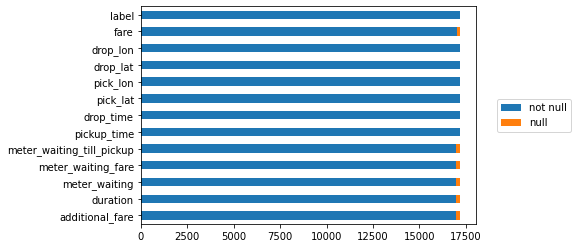

In [0]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

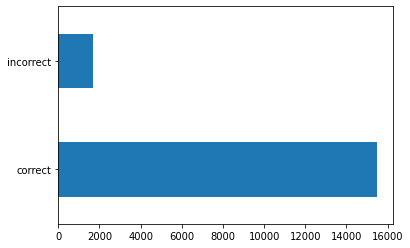

In [0]:
train_df['label'].value_counts().plot.barh()

In [0]:
import keras

from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42  

Using TensorFlow backend.


In [0]:
def preprocessTrainData(train_df):
    #labels
    labels_df = train_df.loc[:, train_df.columns == 'label']
    
    labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
    
    labels_df.columns = labels_df.columns
    labels_df.index = labels_df.index
    
    # features
    features_df = train_df.drop(columns=['label'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df, labels_df

In [0]:
features_df, labels_df = preprocessTrainData(train_df)

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.4,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

NameError: ignored

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(56, activation=tf.nn.relu),
	  keras.layers.Dense(28, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

model.fit(X_train, y_train.values.ravel(), epochs=50, batch_size=1)

Epoch 1/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.3364 - f1_m: 0.8985
Epoch 2/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.2962 - f1_m: 0.8977
Epoch 3/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.2440 - f1_m: 0.8946
Epoch 4/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.2148 - f1_m: 0.8948
Epoch 5/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.2018 - f1_m: 0.8934
Epoch 6/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.1920 - f1_m: 0.8949
Epoch 7/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.1854 - f1_m: 0.8946
Epoch 8/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.2172 - f1_m: 0.8943
Epoch 9/50
10305/10305 [==============================] - 12s 1ms/step - loss: 0.1861 - f1_m: 0.8940
Epoch 10/50
10305/10305 [==============================] - 13s 1ms/step - loss: 0.1940 - f1

In [0]:
model.save('/content/drive/My Drive/Semester 7/Machine Learning/models/submission_1_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Semester 7/Machine Learning/models/submission_1_model/assets


In [0]:
X_train.shape

(10305, 26)

In [0]:
y_pred = model.predict(X_eval)
model.save_model(f'logs/H1N1_{tree_no}_AUC_{best_H1N1}.model')

In [0]:
y_pred

array([[9.9993372e-01],
       [1.1931654e-06],
       [9.3036580e-01],
       ...,
       [5.3188028e-06],
       [9.7466087e-01],
       [9.8387963e-01]], dtype=float32)

In [0]:
test_loss, test_acc = model.evaluate(X_eval, y_eval)

215/215 [==============================] - 0s 1ms/step - loss: 0.3529 - f1_m: 0.9659


In [0]:
y_pred[y_pred >= .5] = 1
y_pred[y_pred < .5] = 0

y_pred

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [0]:
from sklearn.metrics import f1_score

print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score macro: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.966624
F1 score macro: 0.801965


In [0]:
test_features_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/test.csv',index_col="tripid")

In [0]:
def preprocessTestData(test_features_df):
    # features
    features_df = test_features_df
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = RobustScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour'] = features_df['pickup_time'].dt.hour
    features_df['drop_hour'] = features_df['drop_time'].dt.hour
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time'])
    
    return features_df

In [0]:
test_features_df = preprocessTestData(test_features_df)

In [0]:
test_pred = model.predict(test_features_df)
test_pred

array([[0.99995387],
       [0.99474037],
       [0.9909666 ],
       ...,
       [0.95711666],
       [0.97841513],
       [0.7816718 ]], dtype=float32)

In [0]:
test_pred[test_pred >= .5] = 1
test_pred[test_pred < .5] = 0

test_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
submission_df = pd.read_csv('/content/drive/My Drive/Semester 7/Machine Learning/sample_submission.csv',index_col="tripid")
submission_df

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1
...,...
222856243,1
222857785,0
222858416,0


In [0]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [0]:
# Save predictions to submission data frame
submission_df["prediction"] = test_pred

submission_df

,prediction
tripid,
213284604,1.0
213286352,1.0
213293973,1.0
213294622,1.0
213298687,1.0
...,...
222856243,1.0
222857785,1.0
222858416,1.0


In [0]:
submission_df['prediction'] = submission_df['prediction'].astype(int)

In [0]:
submission_df.to_csv('/content/drive/My Drive/Semester 7/Machine Learning/submission1.csv', index=True)